## split dataset

In [ ]:
import os
import shutil
from pathlib import Path
import numpy as np

def read_yolo_label(label_path):
    """Read YOLO label file and return class indices."""
    with open(label_path, 'r') as f:
        lines = f.readlines()
    class_indices = set()
    for line in lines:
        if line.strip():
            class_idx = int(line.split()[0])
            class_indices.add(class_idx)
    return class_indices

def separate_classes(base_dir, split_type):
    """Separate images and labels by class for a given split (train/val)."""
    images_dir = Path(base_dir) / split_type / 'images'
    labels_dir = Path(base_dir) / split_type / 'labels'
    
    # Create dictionary to store class information
    class_files = {}
    
    # Process each label file
    for label_file in labels_dir.glob('*.txt'):
        image_name = label_file.stem
        image_file = images_dir / f"{image_name}.jpg"  # Assuming jpg format, modify if needed
        
        # Skip if image doesn't exist
        if not image_file.exists():
            print(f"Warning: No matching image for {label_file}")
            continue
            
        # Get class indices from label file
        class_indices = read_yolo_label(label_file)
        
        # Add files to corresponding classes
        for class_idx in class_indices:
            if class_idx not in class_files:
                class_files[class_idx] = []
            class_files[class_idx].append((image_file, label_file))
    
    # Create directories and copy files
    for class_idx in class_files:
        # Create class directories
        class_dir = Path(base_dir) / split_type / f'class{class_idx}'
        class_images_dir = class_dir / 'images'
        class_labels_dir = class_dir / 'labels'
        
        os.makedirs(class_images_dir, exist_ok=True)
        os.makedirs(class_labels_dir, exist_ok=True)
        
        # Copy files
        for image_file, label_file in class_files[class_idx]:
            shutil.copy2(image_file, class_images_dir / image_file.name)
            shutil.copy2(label_file, class_labels_dir / label_file.name)
            
        print(f"{split_type}/class{class_idx}: {len(class_files[class_idx])} files")

def main():
    base_dir = 'dsds'  # Change this to your dataset path
    
    # Process both train and val splits
    for split_type in ['train', 'val']:
        print(f"\nProcessing {split_type} split:")
        separate_classes(base_dir, split_type)

if __name__ == "__main__":
    main()

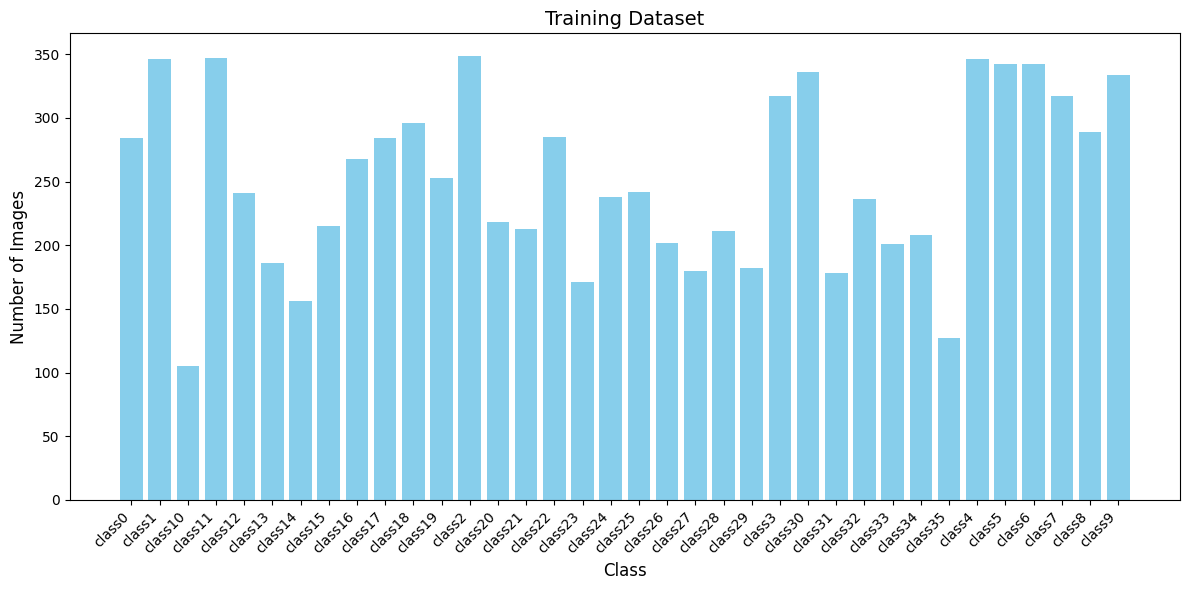

In [2]:
import os
import matplotlib.pyplot as plt

# Path to your training dataset
train_dir = "dsds/train"

# Count images per class
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name, "images")
    if os.path.isdir(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

# Sort the counts for better visualization
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Training Dataset", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


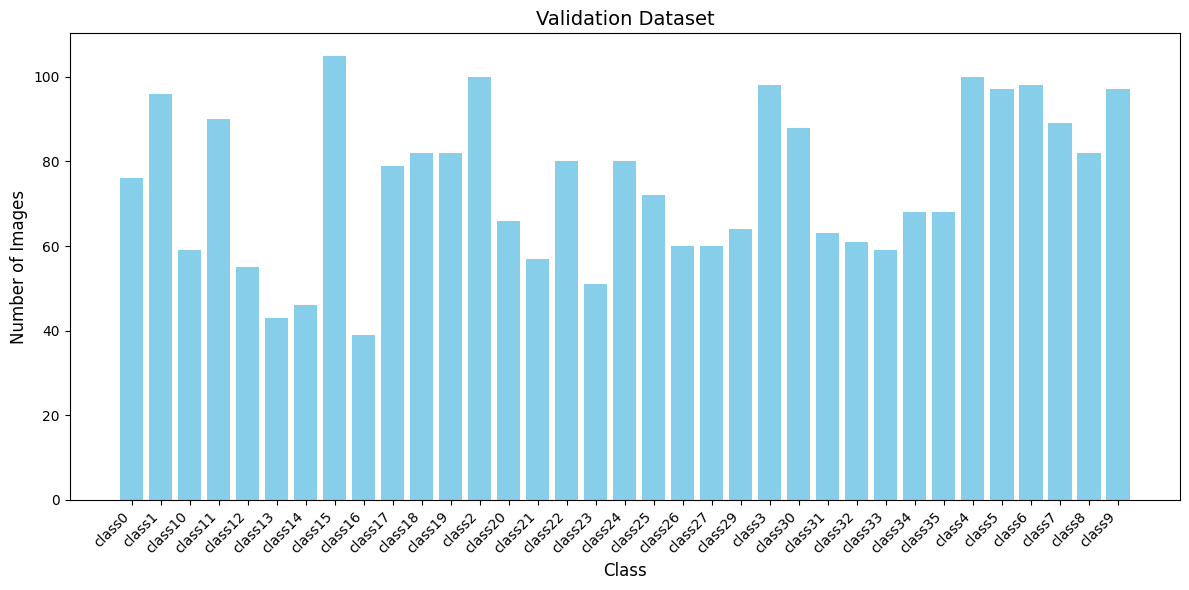

In [3]:
import os
import matplotlib.pyplot as plt

# Path to your training dataset
train_dir = "dsds/val"

# Count images per class
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name, "images")
    if os.path.isdir(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

# Sort the counts for better visualization
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Validation Dataset", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


## Start Generating for training set

In [ ]:
import os
import random
from PIL import Image
from collections import defaultdict

def apply_zoom(image_path, label_path, zoom_factor, output_image_path, output_label_path):
    """
    Apply zoom augmentation to an image and its labels with improved bounding box adjustment
    
    Args:
    - image_path: Path to the input image
    - label_path: Path to the input label file
    - zoom_factor: Factor by which to zoom (> 1)
    - output_image_path: Path to save the zoomed image
    - output_label_path: Path to save the zoomed labels
    """
    # Load the image
    image = Image.open(image_path)
    img_width, img_height = image.size

    # Calculate crop dimensions for zoom
    crop_width = img_width / zoom_factor
    crop_height = img_height / zoom_factor
    left = (img_width - crop_width) / 2
    top = (img_height - crop_height) / 2
    right = left + crop_width
    bottom = top + crop_height

    # Crop and resize the image back to original dimensions
    cropped_image = image.crop((left, top, right, bottom))
    zoomed_image = cropped_image.resize((img_width, img_height), Image.LANCZOS)

    # Adjust bounding box labels
    zoomed_labels = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            # Convert normalized coordinates to pixel coordinates
            px_x_center = x_center * img_width
            px_y_center = y_center * img_height
            px_width = width * img_width
            px_height = height * img_height

            # Adjust pixel coordinates based on crop
            px_x_center = (px_x_center - left) * zoom_factor
            px_y_center = (px_y_center - top) * zoom_factor

            # Adjust pixel width and height
            px_width *= zoom_factor
            px_height *= zoom_factor

            # Convert back to normalized coordinates
            new_x_center = px_x_center / img_width
            new_y_center = px_y_center / img_height
            new_width = px_width / img_width
            new_height = px_height / img_height

            # Ensure bounding box stays within image bounds
            new_x_center = min(max(new_x_center, new_width/2), 1 - new_width/2)
            new_y_center = min(max(new_y_center, new_height/2), 1 - new_height/2)

            # Add the modified label
            zoomed_labels.append(f"{class_id} {new_x_center:.6f} {new_y_center:.6f} {new_width:.6f} {new_height:.6f}")

    # Save the zoomed image and labels
    zoomed_image.save(output_image_path)
    with open(output_label_path, 'w') as f:
        f.writelines('\n'.join(zoomed_labels) + '\n')

def balance_dataset(base_path, target_count=350):
    """Balance all classes to have target_count images using zoom augmentation"""
    # Available zoom factors with more fine-grained progression
    zoom_factors = [round(x * 0.02 + 1.04, 2) for x in range(7)]  # [1.04, 1.06, 1.08, 1.10, 1.12, 1.14, 1.16]
    
    # Process each class directory
    class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d)) and d.startswith('class')]
    
    for class_dir in class_dirs:
        class_path = os.path.join(base_path, class_dir)
        images_dir = os.path.join(class_path, 'images')
        labels_dir = os.path.join(class_path, 'labels')
        
        # Ensure directories exist
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(labels_dir, exist_ok=True)
        
        # Get list of original images (without zoom annotations)
        original_images = [f for f in os.listdir(images_dir) 
                         if f.endswith(('.jpg', '.jpeg', '.png')) and '(z' not in f]
        
        print(f"\nProcessing {class_dir}:")
        print(f"Original images: {len(original_images)}")
        
        current_count = len([f for f in os.listdir(images_dir) 
                           if f.endswith(('.jpg', '.jpeg', '.png'))])
        num_needed = max(0, target_count - current_count)
        
        print(f"Current total images: {current_count}")
        print(f"Additional images needed: {num_needed}")
        
        if num_needed == 0:
            print("No augmentation needed for this class")
            continue

        # Keep track of used zoom factors for each image
        used_zoom_factors = defaultdict(set)
        
        # Calculate maximum augmentations possible
        max_possible = len(original_images) * len(zoom_factors)
        if max_possible < num_needed:
            print(f"Warning: Can only generate {max_possible} unique augmentations "
                  f"({len(original_images)} images × {len(zoom_factors)} zoom factors)")
            num_needed = max_possible
        
        augmentations_created = 0
        attempts = 0
        max_attempts = num_needed * 3  # Prevent infinite loop
        
        while augmentations_created < num_needed and attempts < max_attempts:
            attempts += 1
            
            # Get a random original image
            image_file = random.choice(original_images)
            
            # Get available zoom factors for this image
            available_factors = [f for f in zoom_factors 
                               if f not in used_zoom_factors[image_file]]
            
            if not available_factors:
                continue  # Skip if no available zoom factors for this image
                
            # Choose random zoom factor from available ones
            zoom_factor = random.choice(available_factors)
            used_zoom_factors[image_file].add(zoom_factor)
            
            # Setup paths
            label_file = os.path.splitext(image_file)[0] + '.txt'
            image_path = os.path.join(images_dir, image_file)
            label_path = os.path.join(labels_dir, label_file)
            
            # Verify label file exists
            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_file}")
                continue
            
            # Create output filenames with zoom factor
            base_name = os.path.splitext(image_file)[0]
            ext = os.path.splitext(image_file)[1]
            new_image_name = f"{base_name}(z{zoom_factor}){ext}"
            new_label_name = f"{base_name}(z{zoom_factor}).txt"
            
            output_image_path = os.path.join(images_dir, new_image_name)
            output_label_path = os.path.join(labels_dir, new_label_name)
            
            # Apply zoom augmentation
            apply_zoom(image_path, label_path, zoom_factor, output_image_path, output_label_path)
            
            augmentations_created += 1
            if augmentations_created % 10 == 0:
                print(f"Generated {augmentations_created}/{num_needed} augmented images")
        
        # Print statistics
        print(f"\nCompleted augmentation for {class_dir}")
        print(f"Total augmented images created: {augmentations_created}")
        print("\nZoom factors used per image:")
        for img, factors in used_zoom_factors.items():
            if factors:
                print(f"  {img}: {sorted(factors)}")

if __name__ == "__main__":
    # Path to your dataset directory containing class0, class1, etc.
    dataset_path = "dsds/train"  # Adjust this to your dataset path
    
    print("Starting dataset balancing...")
    balance_dataset(dataset_path)
    print("\nDataset balancing completed!")

## New Data Count for Train

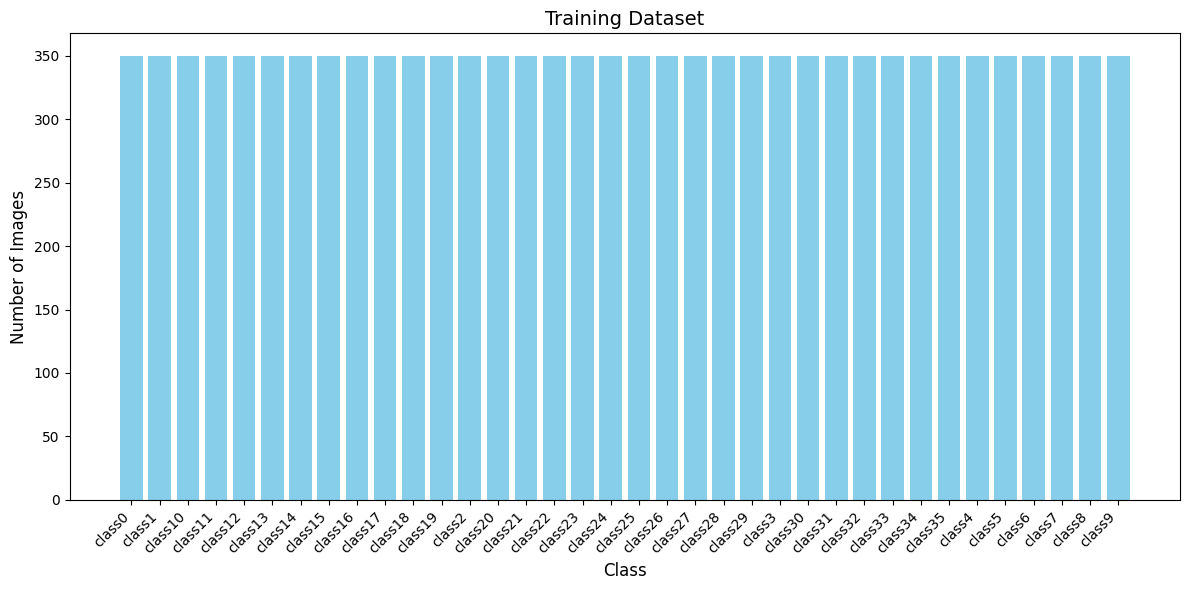

In [5]:
import os
import matplotlib.pyplot as plt

# Path to your training dataset
train_dir = "dsds/train"

# Count images per class
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name, "images")
    if os.path.isdir(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

# Sort the counts for better visualization
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Training Dataset", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


## Start Generating for validation set

In [ ]:
import os
import random
from PIL import Image
from collections import defaultdict

def apply_zoom(image_path, label_path, zoom_factor, output_image_path, output_label_path):
    """
    Apply zoom augmentation to an image and its labels with improved bounding box adjustment
    
    Args:
    - image_path: Path to the input image
    - label_path: Path to the input label file
    - zoom_factor: Factor by which to zoom (> 1)
    - output_image_path: Path to save the zoomed image
    - output_label_path: Path to save the zoomed labels
    """
    # Load the image
    image = Image.open(image_path)
    img_width, img_height = image.size

    # Calculate crop dimensions for zoom
    crop_width = img_width / zoom_factor
    crop_height = img_height / zoom_factor
    left = (img_width - crop_width) / 2
    top = (img_height - crop_height) / 2
    right = left + crop_width
    bottom = top + crop_height

    # Crop and resize the image back to original dimensions
    cropped_image = image.crop((left, top, right, bottom))
    zoomed_image = cropped_image.resize((img_width, img_height), Image.LANCZOS)

    # Adjust bounding box labels
    zoomed_labels = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            # Convert normalized coordinates to pixel coordinates
            px_x_center = x_center * img_width
            px_y_center = y_center * img_height
            px_width = width * img_width
            px_height = height * img_height

            # Adjust pixel coordinates based on crop
            px_x_center = (px_x_center - left) * zoom_factor
            px_y_center = (px_y_center - top) * zoom_factor

            # Adjust pixel width and height
            px_width *= zoom_factor
            px_height *= zoom_factor

            # Convert back to normalized coordinates
            new_x_center = px_x_center / img_width
            new_y_center = px_y_center / img_height
            new_width = px_width / img_width
            new_height = px_height / img_height

            # Ensure bounding box stays within image bounds
            new_x_center = min(max(new_x_center, new_width/2), 1 - new_width/2)
            new_y_center = min(max(new_y_center, new_height/2), 1 - new_height/2)

            # Add the modified label
            zoomed_labels.append(f"{class_id} {new_x_center:.6f} {new_y_center:.6f} {new_width:.6f} {new_height:.6f}")

    # Save the zoomed image and labels
    zoomed_image.save(output_image_path)
    with open(output_label_path, 'w') as f:
        f.writelines('\n'.join(zoomed_labels) + '\n')

def balance_dataset(base_path, target_count=100):
    """Balance all classes to have target_count images using zoom augmentation"""
    # Available zoom factors with more fine-grained progression
    zoom_factors = [round(x * 0.02 + 1.04, 2) for x in range(7)]  # [1.04, 1.06, 1.08, 1.10, 1.12, 1.14, 1.16]
    
    # Process each class directory
    class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d)) and d.startswith('class')]
    
    for class_dir in class_dirs:
        class_path = os.path.join(base_path, class_dir)
        images_dir = os.path.join(class_path, 'images')
        labels_dir = os.path.join(class_path, 'labels')
        
        # Ensure directories exist
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(labels_dir, exist_ok=True)
        
        # Get list of original images (without zoom annotations)
        original_images = [f for f in os.listdir(images_dir) 
                         if f.endswith(('.jpg', '.jpeg', '.png')) and '(z' not in f]
        
        print(f"\nProcessing {class_dir}:")
        print(f"Original images: {len(original_images)}")
        
        current_count = len([f for f in os.listdir(images_dir) 
                           if f.endswith(('.jpg', '.jpeg', '.png'))])
        num_needed = max(0, target_count - current_count)
        
        print(f"Current total images: {current_count}")
        print(f"Additional images needed: {num_needed}")
        
        if num_needed == 0:
            print("No augmentation needed for this class")
            continue

        # Keep track of used zoom factors for each image
        used_zoom_factors = defaultdict(set)
        
        # Calculate maximum augmentations possible
        max_possible = len(original_images) * len(zoom_factors)
        if max_possible < num_needed:
            print(f"Warning: Can only generate {max_possible} unique augmentations "
                  f"({len(original_images)} images × {len(zoom_factors)} zoom factors)")
            num_needed = max_possible
        
        augmentations_created = 0
        attempts = 0
        max_attempts = num_needed * 3  # Prevent infinite loop
        
        while augmentations_created < num_needed and attempts < max_attempts:
            attempts += 1
            
            # Get a random original image
            image_file = random.choice(original_images)
            
            # Get available zoom factors for this image
            available_factors = [f for f in zoom_factors 
                               if f not in used_zoom_factors[image_file]]
            
            if not available_factors:
                continue  # Skip if no available zoom factors for this image
                
            # Choose random zoom factor from available ones
            zoom_factor = random.choice(available_factors)
            used_zoom_factors[image_file].add(zoom_factor)
            
            # Setup paths
            label_file = os.path.splitext(image_file)[0] + '.txt'
            image_path = os.path.join(images_dir, image_file)
            label_path = os.path.join(labels_dir, label_file)
            
            # Verify label file exists
            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_file}")
                continue
            
            # Create output filenames with zoom factor
            base_name = os.path.splitext(image_file)[0]
            ext = os.path.splitext(image_file)[1]
            new_image_name = f"{base_name}(z{zoom_factor}){ext}"
            new_label_name = f"{base_name}(z{zoom_factor}).txt"
            
            output_image_path = os.path.join(images_dir, new_image_name)
            output_label_path = os.path.join(labels_dir, new_label_name)
            
            # Apply zoom augmentation
            apply_zoom(image_path, label_path, zoom_factor, output_image_path, output_label_path)
            
            augmentations_created += 1
            if augmentations_created % 10 == 0:
                print(f"Generated {augmentations_created}/{num_needed} augmented images")
        
        # Print statistics
        print(f"\nCompleted augmentation for {class_dir}")
        print(f"Total augmented images created: {augmentations_created}")
        print("\nZoom factors used per image:")
        for img, factors in used_zoom_factors.items():
            if factors:
                print(f"  {img}: {sorted(factors)}")

if __name__ == "__main__":
    # Path to your dataset directory containing class0, class1, etc.
    dataset_path = "dsds/val"  # Adjust this to your dataset path
    
    print("Starting dataset balancing...")
    balance_dataset(dataset_path)
    print("\nDataset balancing completed!")

## New Data Count for Val

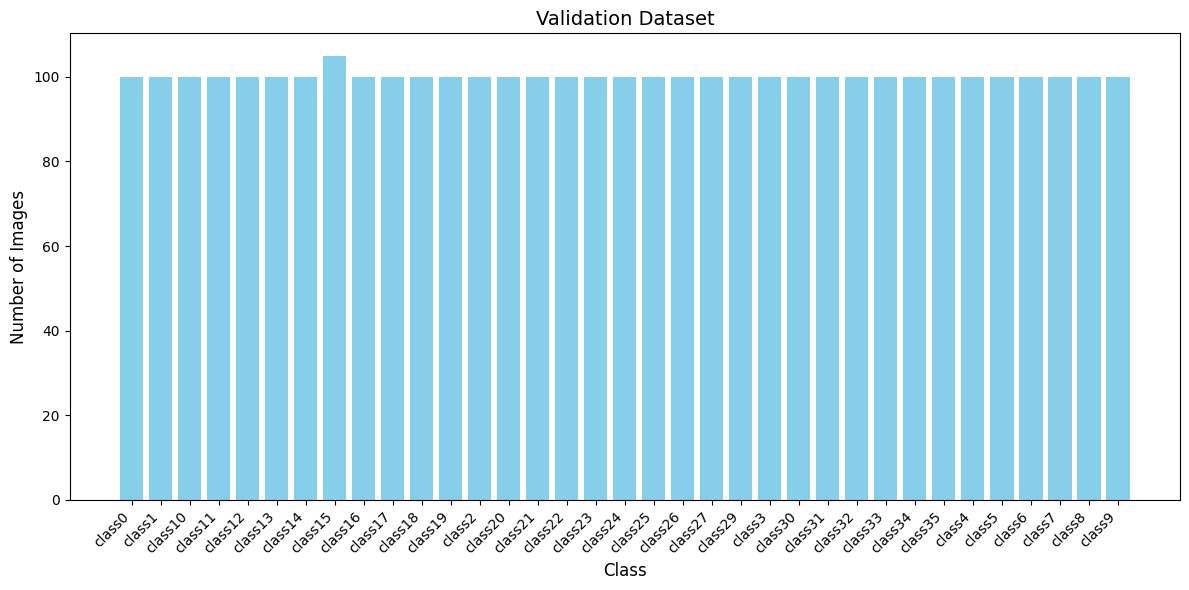

In [2]:
import os
import matplotlib.pyplot as plt

# Path to your training dataset
train_dir = "dsds/val"

# Count images per class
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name, "images")
    if os.path.isdir(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

# Sort the counts for better visualization
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Validation Dataset", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
import os
import random

def cleanup_excess_images(base_path='dsds/val', target_count=100):
    """
    Randomly delete images and labels for classes that exceed the target count.
    
    Args:
    - base_path: Path to the dataset directory containing the validation dataset (default is 'dsds/val').
    - target_count: Maximum number of images allowed per class.
    """
    # Iterate through each class directory
    class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

    for class_dir in class_dirs:
        class_path = os.path.join(base_path, class_dir)
        images_dir = os.path.join(class_path, 'images')
        labels_dir = os.path.join(class_path, 'labels')
        
        if not os.path.exists(images_dir) or not os.path.exists(labels_dir):
            print(f"Skipping {class_dir}: 'images' or 'labels' directory not found.")
            continue
        
        # Get list of all images
        all_images = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]
        current_count = len(all_images)
        
        print(f"\nProcessing {class_dir}:")
        print(f"Current image count: {current_count}")
        
        if current_count > target_count:
            num_to_delete = current_count - target_count
            print(f"Need to delete {num_to_delete} images.")
            
            # Prefer deleting augmented images first (identified by patterns like '(z' in filename)
            augmented_images = [img for img in all_images if '(z' in img]
            deletion_candidates = augmented_images if augmented_images else all_images
            
            # Randomly select images to delete
            images_to_delete = random.sample(deletion_candidates, num_to_delete)
            
            # Delete selected images and their corresponding labels
            for image_to_delete in images_to_delete:
                # Remove image
                image_path = os.path.join(images_dir, image_to_delete)
                os.remove(image_path)
                
                # Remove corresponding label
                label_name = os.path.splitext(image_to_delete)[0] + '.txt'
                label_path = os.path.join(labels_dir, label_name)
                if os.path.exists(label_path):
                    os.remove(label_path)
            
            # Verify final count
            remaining_images = len([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))])
            print(f"Images after cleanup: {remaining_images}")
        else:
            print(f"No deletion required for {class_dir}.")

# Call the function
cleanup_excess_images(base_path='dsds/val', target_count=100)


## Val Data Count After Cleanup

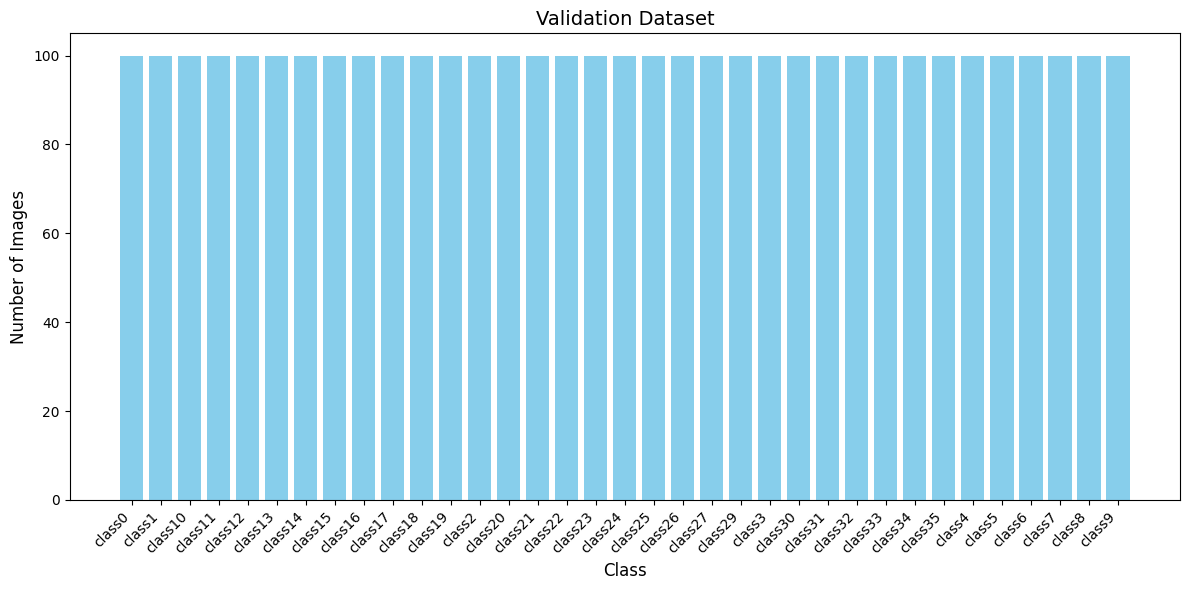

In [15]:
import os
import matplotlib.pyplot as plt

# Path to your training dataset
train_dir = "dsds/val"

# Count images per class
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name, "images")
    if os.path.isdir(class_path):
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

# Sort the counts for better visualization
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Validation Dataset", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


## Plot Random Samples from Train

Plotting random samples from the dataset...


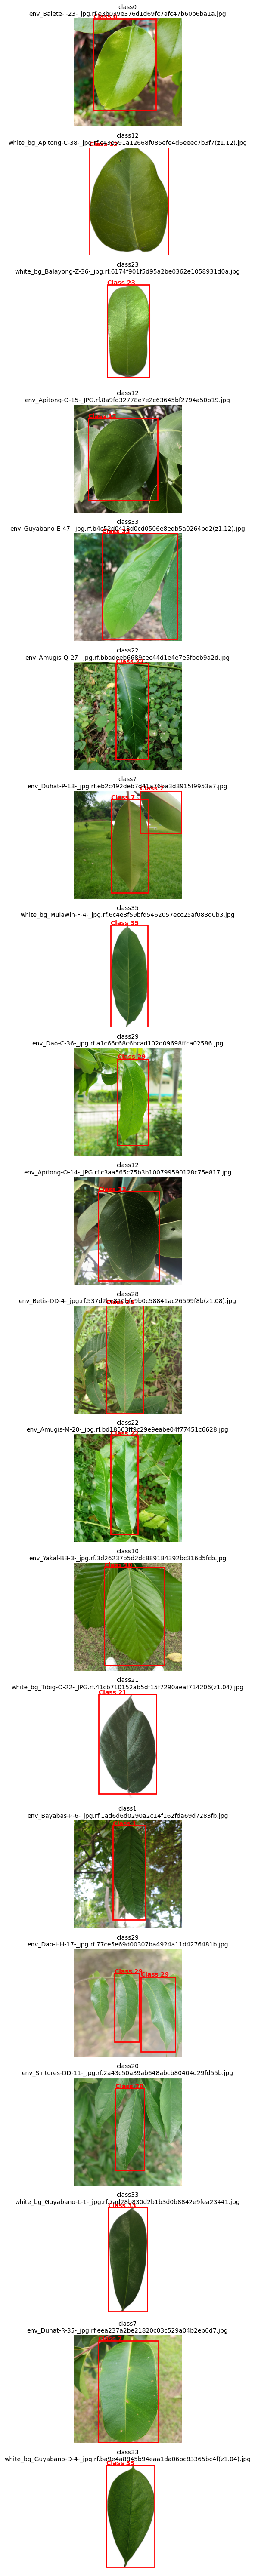

Done!


In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot_image_with_boxes(image_path, label_path, ax, title):
    """Plot an image with its bounding boxes and title"""
    # Load image
    image = Image.open(image_path)
    img_width, img_height = image.size

    # Plot image
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(title, fontsize=10, wrap=True)

    # Read and plot bounding boxes
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])

                # Convert YOLO format to corner coordinates
                x_min = (x_center - width / 2) * img_width
                y_min = (y_center - height / 2) * img_height
                box_width = width * img_width
                box_height = height * img_height

                # Draw bounding box
                rect = patches.Rectangle(
                    (x_min, y_min), box_width, box_height,
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                ax.add_patch(rect)
                ax.text(x_min, y_min - 5, f"Class {class_id}", 
                        color='red', fontsize=10, weight='bold')

def plot_random_dataset_samples(base_path, num_samples=20, figsize=(3, 3)):
    """Plot random samples from the dataset in a single column"""
    # Get all class directories
    class_dirs = [d for d in os.listdir(base_path) if d.startswith('class')]
    
    # Collect all image paths and their corresponding label paths
    all_images = []
    for class_dir in class_dirs:
        images_dir = os.path.join(base_path, class_dir, 'images')
        labels_dir = os.path.join(base_path, class_dir, 'labels')
        
        for image_file in os.listdir(images_dir):
            if image_file.endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(images_dir, image_file)
                label_path = os.path.join(labels_dir, 
                                        os.path.splitext(image_file)[0] + '.txt')
                all_images.append((image_path, label_path, class_dir))
    
    # Randomly select images
    selected_images = random.sample(all_images, min(num_samples, len(all_images)))
    
    # Create subplot grid for a single column
    num_rows = len(selected_images)
    fig, axs = plt.subplots(num_rows, 1, figsize=(figsize[0], num_rows * figsize[1]))
    
    if num_rows == 1:  # Handle case where only one sample is selected
        axs = [axs]
    
    # Plot each selected image
    for i, (image_path, label_path, class_dir) in enumerate(selected_images):
        # Create title from filename and class
        filename = os.path.basename(image_path)
        title = f"{class_dir}\n{filename}"
        
        # Plot image with boxes
        plot_image_with_boxes(image_path, label_path, axs[i], title)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Path to your dataset directory containing class0, class1, etc.
    dataset_path = "dsds/train"  # Adjust this to your dataset path
    
    print("Plotting random samples from the dataset...")
    plot_random_dataset_samples(dataset_path, num_samples=20)
    print("Done!")


## Plot Random Samples from Val

Plotting random samples from the dataset...


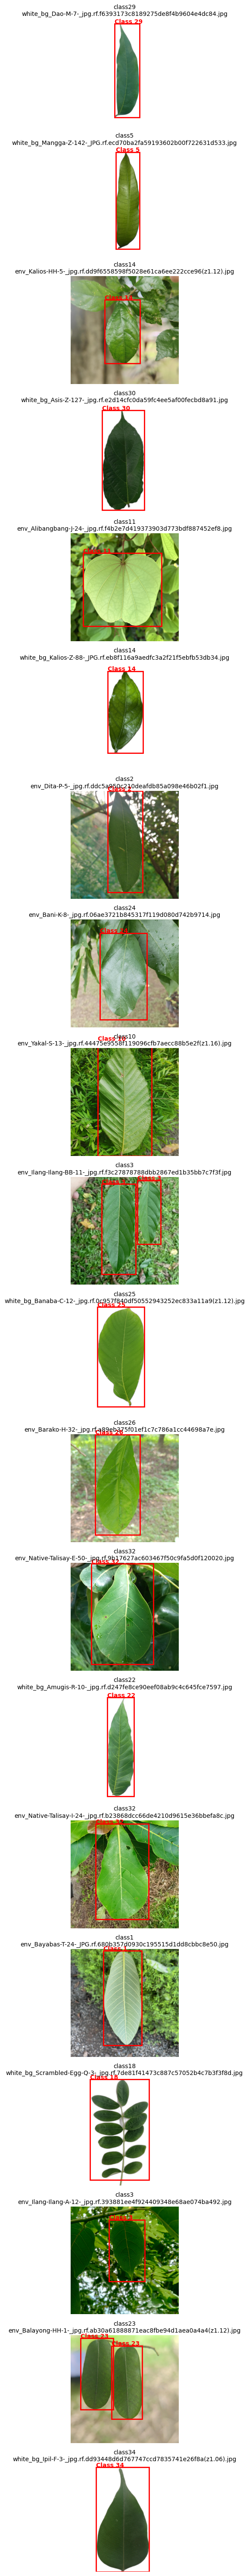

Done!


In [20]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot_image_with_boxes(image_path, label_path, ax, title):
    """Plot an image with its bounding boxes and title"""
    # Load image
    image = Image.open(image_path)
    img_width, img_height = image.size

    # Plot image
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(title, fontsize=10, wrap=True)

    # Read and plot bounding boxes
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])

                # Convert YOLO format to corner coordinates
                x_min = (x_center - width / 2) * img_width
                y_min = (y_center - height / 2) * img_height
                box_width = width * img_width
                box_height = height * img_height

                # Draw bounding box
                rect = patches.Rectangle(
                    (x_min, y_min), box_width, box_height,
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                ax.add_patch(rect)
                ax.text(x_min, y_min - 5, f"Class {class_id}", 
                        color='red', fontsize=10, weight='bold')

def plot_random_dataset_samples(base_path, num_samples=20, figsize=(3, 3)):
    """Plot random samples from the dataset in a single column"""
    # Get all class directories
    class_dirs = [d for d in os.listdir(base_path) if d.startswith('class')]
    
    # Collect all image paths and their corresponding label paths
    all_images = []
    for class_dir in class_dirs:
        images_dir = os.path.join(base_path, class_dir, 'images')
        labels_dir = os.path.join(base_path, class_dir, 'labels')
        
        for image_file in os.listdir(images_dir):
            if image_file.endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(images_dir, image_file)
                label_path = os.path.join(labels_dir, 
                                        os.path.splitext(image_file)[0] + '.txt')
                all_images.append((image_path, label_path, class_dir))
    
    # Randomly select images
    selected_images = random.sample(all_images, min(num_samples, len(all_images)))
    
    # Create subplot grid for a single column
    num_rows = len(selected_images)
    fig, axs = plt.subplots(num_rows, 1, figsize=(figsize[0], num_rows * figsize[1]))
    
    if num_rows == 1:  # Handle case where only one sample is selected
        axs = [axs]
    
    # Plot each selected image
    for i, (image_path, label_path, class_dir) in enumerate(selected_images):
        # Create title from filename and class
        filename = os.path.basename(image_path)
        title = f"{class_dir}\n{filename}"
        
        # Plot image with boxes
        plot_image_with_boxes(image_path, label_path, axs[i], title)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Path to your dataset directory containing class0, class1, etc.
    dataset_path = "dsds/val"  # Adjust this to your dataset path
    
    print("Plotting random samples from the dataset...")
    plot_random_dataset_samples(dataset_path, num_samples=20)
    print("Done!")


## Plot Specific Image

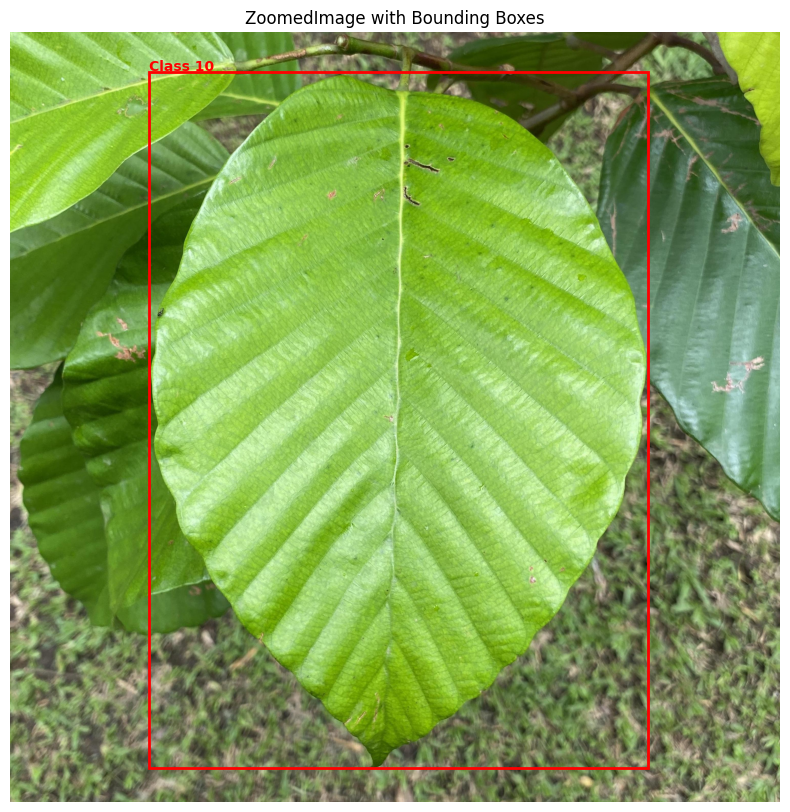

In [18]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to plot image with bounding boxes
def plot_image_with_boxes(image_path, label_path):
    # Load image
    image = Image.open(image_path)
    img_width, img_height = image.size

    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    ax.axis('off')
    ax.set_title("ZoomedImage with Bounding Boxes")

    # Read and plot bounding boxes
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            # Convert YOLO format to corner coordinates
            x_min = (x_center - width / 2) * img_width
            y_min = (y_center - height / 2) * img_height
            x_max = (x_center + width / 2) * img_width
            y_max = (y_center + height / 2) * img_height

            # Draw bounding box
            rect = patches.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(x_min, y_min - 5, f"Class {class_id}", color='red', fontsize=10, weight='bold')

    plt.show()

# File paths
image_path = "dsds/train/class10/images/env_Yakal-TT-4-_jpg.rf.c4a9f23d37668bbb11a7631a06058356(z1.16).jpg"
label_path = "dsds/train/class10/labels/env_Yakal-TT-4-_jpg.rf.c4a9f23d37668bbb11a7631a06058356(z1.16).txt"

# Plot the image with bounding boxes
plot_image_with_boxes(image_path, label_path)


## Restructure Data for Training

In [19]:
import os
import shutil

# Source and destination paths
source_dir = "dsds"
dest_dir = "Augmented_Dataset"

def copy_files(source, destination):
    if not os.path.exists(destination):
        os.makedirs(destination)

    for root, _, files in os.walk(source):
        for file in files:
            file_path = os.path.join(root, file)
            shutil.copy(file_path, destination)

# Paths for train and val datasets
train_images_dest = os.path.join(dest_dir, "train", "images")
train_labels_dest = os.path.join(dest_dir, "train", "labels")
val_images_dest = os.path.join(dest_dir, "val", "images")
val_labels_dest = os.path.join(dest_dir, "val", "labels")

# Function to copy images and labels
print("Copying training images and labels...")
for class_idx in range(36):
    class_path = f"class{class_idx}"
    copy_files(os.path.join(source_dir, "train", class_path, "images"), train_images_dest)
    copy_files(os.path.join(source_dir, "train", class_path, "labels"), train_labels_dest)

print("Copying validation images and labels...")
for class_idx in range(36):
    class_path = f"class{class_idx}"
    copy_files(os.path.join(source_dir, "val", class_path, "images"), val_images_dest)
    copy_files(os.path.join(source_dir, "val", class_path, "labels"), val_labels_dest)

print("Dataset reorganization complete.")


Copying training images and labels...
Copying validation images and labels...
Dataset reorganization complete.
